# Describing model predictions, using SHAP values and SHAP interactions: Using Titanic survival as an example use case.

## Plain English summary

When fitting a machine learning model to data to make a prediction, it is now possible, with the use of the SHAP library, to allocate contributions of the prediction onto the feature values. This means that we can now turn these black box methods into transparent models and describe what the model used to obtain it's prediction.

SHAP values are calculated for each feature of each instance for a fitted model. In addition there is the SHAP base value which is the same value for all of the instances. The base value represents the models best guess for any instance without any extra knowledge about the instance (this can also be thought of as the "expected value"). It is possible to obtain the models prediction of an instance by taking the sum of the SHAP base value and each of the SHAP values for the features. This allows the prediction from a model to be transparant, and we can rank the features by their importance in determining the prediction for each instance.

In our previous notebooks (03_xgb_combined_shap_key_features.ipynb) we saw that a feature with the same value in multiple instances (such as all of the patients that attend hospital A), the feature (Hospital A) does not necessarily have the same SHAP value in all of those instances. This means that the feature value alone is not a clear indication of the impact it will have on the prediction - this is due to there being feature interactions, such that SHAP values for a feature are influenced by the other feature values. This means that SHAP values are instance dependent (as they are also capturing the interactions between pairs of feature values). The SHAP values therefore are in turn made up of a main effect (what is due to the feature value, the standalone effect) and also the interactions with the other features (a value per feature pairings).

[Note: In this notebook we will refer to the parts of the SHAP value consistently as base value, main effect, and interactions, where the term SHAP feature value refers to the sum of the main effect and interactions].

SHAP values are in the same units as the model output (for XGBoost these are in log odds). 

Here we fit an XGBoost model to the Titanic dataset, to predict whether a passenger survives from the values of four features (gender, age, ticket class, number of siblings). We calculate the SHAP values (base, main effect and feature interactions) of this fitted model and show the most useful way (that we have found) to present all of these values in order to gain the most insight into how the model is working. At present this is using a grid of SHAP dependency plots.

This notebook is based on the blog https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a

## Model and data

XGBoost models were trained on all of the data (not split into training and test set). The four features in the model are:

* male: gender of the passenger (0 = female, 1 = male)
* Pclass: Class of the ticket (1 = first, 2 = second, 3 = third class)
* Age: Age of passenger, in years
* SibSp: Number of siblings

And one target feature:
* Survived: Did the passenger survive the sinking of the Titanic (0 = not survive, 1 = survive)

## Aims

* Fit XGBoost model using feature data to predict whether passenger survived
* Calculate the SHAP main effect and SHAP interaction values
* Understand the SHAP main effect and SHAP interaction values
* Find the best way to display these values in order to gain the most insight into the relationships that the model is using

## Observations

* SHAP interactions are awesome! 
* Viewing them as a grid of SHAP dependency plots clearly shows the overall relationships that the model uses to derive it's predictions for the whole dataset.

## Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from xgboost import XGBClassifier

# Import shap for shapley values
import shap # `pip install shap` if neeed

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

from scipy import stats

/home/michael/miniconda3/envs/samuel/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Load data

The section below downloads pre-processed data, and saves it to a subfolder (from where this code is run).
If data has already been downloaded that cell may be skipped.

Code that was used to pre-process the data ready for machine learning may be found at:
https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/01_preprocessing.ipynb

In [2]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

In [3]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)

# Restirct to 4 features + target for this example
features = ['male', 'Pclass', 'Age', 'SibSp', 'Survived']
data = data[features]

## Divide into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (survived or not) `y`.

In [4]:
# Use `survived` field as y, and drop for X
y = data['Survived'] # y = 'survived' column from 'data'
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column

Average survival (this is the expected outcome of each passenger, without knowing anything about the passenger)

In [5]:
print (f'Average survival: {round(y.mean(),2)}')

Average survival: 0.38


## Fit XGBoost model

We will fit a model to all of the data (rather than train/test splits used to assess accuracy).

In [6]:
model = XGBClassifier(random_state=42)
model.fit(X, y)

[06:32:28] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=36,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Get the predictions for each passenger (in terms of the class, and the probability of being in either class)

In [7]:
y_pred = model.predict(X)
y_proba = model.predict_proba(X)

Calculate the models accuracy

In [8]:
accuracy = np.mean(y == y_pred)
print(f'Model accuracy: {accuracy:0.3f}')

Model accuracy: 0.890


## Get SHAP values

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees.
Using this we can calculate the SHAP values.

In [9]:
# Set up the method to estimate SHAP values for tree models and ensembles of
# trees
explainer = shap.TreeExplainer(model)

# Get SHAP values
shap_values = explainer(X)

The explainer returns the base value which is the same value for all instances [shap_value.base_values], the shap values per feature [shap_value.values]. It also returns the feature dataset values [shap_values.data]. You can (sometimes!) access the feature names from the explainer [explainer.data_feature_names].

Let's take a look at the data held for the first instance:
* .values has the SHAP value for each of the four features.
* .base_values has the best guess value without knowing anything about the instance.
* .data has each of the feature values

In [10]:
shap_values[0]

.values =
array([-0.9542305 , -0.45835936, -0.19479564,  0.3371251 ], dtype=float32)

.base_values =
-0.5855415

.data =
array([ 1.,  3., 22.,  1.])

There is one of these for each instance.

In [11]:
shap_values.shape

(891, 4)

### View SHAP values using beeswarm plot

The beeswarm plot gives a good visual representation of the general SHAP value pattern for the whole dataset. 

Each feature is shown on a separate row. It shows the distribution of the SHAP values for each feature. The colour represents the feature data value, and the shape of the data points represent the distribution of the features SHAP values (with a bulge representing a larger number of points, and a thin row representing fewer points). A SHAP value less than 0 (as seen on the x-axis) contributes to the likelihood that the passenger will not survive, whereas a SHAP value greater than 0 contributes to the likelihood that the passenger will survive.

The actual predction of whether a passenger will survive is the sum of each of the SHAP feature values and the SHAP base value.

Here we see that the first line on the beeswarm represents the feature male. A red data points represents a high data value (a male passenger), and a blue datapoint represents a low data value (a female passenger). Being male contributes to the likelihood that they will not survive, whereas being female contributes to the likelihood that they will survive. Female passengers can have a stronger contribution to the outcome (up to +4) than compared to the males (down to -2).

The third line on the beeswarm represents the feature Age. A red data points represents a high data value (an old passenger), a purple datapoint represents a mid point (a middle aged passenger) and a blue datapoint represents a child. The older the passenger the stronger the contribution to the likelihood that they will not survive, the younger the passenger the stronger the contribution to the likelihood that they will survive. There are more datapoints around the 0 SHAP value (which are coloured purple, and so represent the middle aged passengers) than at the extremes.

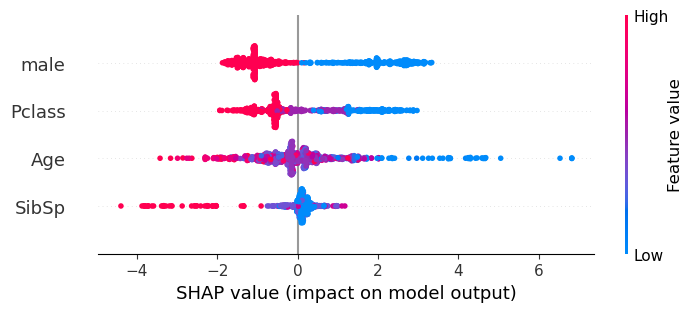

In [12]:
shap.plots.beeswarm(shap_values,show=False)

## Get SHAP interaction values
Use the TreeExplainer to also calculate the SHAP main effect and SHAP interaction values (the sum of which give the SHAP values for each feature).

In [13]:
# Get SHAP interaction values
shap_interaction = explainer.shap_interaction_values(X)

SHAP interaction values have a matrix of values (per pair of features) per instance.\
In this case, each of the 891 instances has a 4x4 matrix of SHAP interaction values (with the SHAP main effect on the diagonal positions).

In [14]:
shap_interaction.shape

(891, 4, 4)

Show SHAP interation matrix (with main effect on the diagonal positions) for the first instance. Notice how the SHAP interation for pairs of features are symmetrical across the diagonal.

In [15]:
shap_interaction[0]

array([[-1.1492473 ,  0.21919565, -0.10196039,  0.07778157],
       [ 0.2191957 , -0.8288462 ,  0.12132409,  0.02996704],
       [-0.10196033,  0.12132414, -0.45647746,  0.24231802],
       [ 0.07778165,  0.0299671 ,  0.242318  , -0.01294166]],
      dtype=float32)

### SHAP interaction matrix: show mean absolute values
Here we see the absolute mean of the SHAP interaction values for all of the instances.\
The values on the diagonal show the main effect for the feature, and the other values show the SHAP interaction for pairs of features (these are symetrical across the diagonal)

In [16]:
mean_abs_interactions = pd.DataFrame(
    np.abs(shap_interaction).mean(axis=(0)),
    index=X.columns, columns=X.columns)

mean_abs_interactions.round(2)

,male,Pclass,Age,SibSp
male,1.41,0.31,0.26,0.05
Pclass,0.31,0.81,0.22,0.04
Age,0.26,0.22,0.68,0.17
SibSp,0.05,0.04,0.17,0.25


### The proportion of SHAP that is from the interactions: calculated from the absolute mean
Looking at all of the instances together, what proportion of the SHAP value comes from the SHAP interations

In [17]:
total_shap = mean_abs_interactions.sum().sum()

interaction_shap = (mean_abs_interactions.sum().sum() - 
                    np.diagonal(mean_abs_interactions).sum().sum())

print(f'The proportion of the SHAP values coming from the interactions are: '
      f'{interaction_shap/total_shap:0.3f}')
print(f'The proportion of the SHAP values coming from the main effects are: '
      f'{1 - (interaction_shap/total_shap):0.3f}')

The proportion of the SHAP values coming from the interactions are: 0.400
The proportion of the SHAP values coming from the main effects are: 0.600


### The proportion of SHAP that is from the interactions: calculated per instance from the absolute values
Looking at each instances, what proportion of the SHAP value comes from the SHAP interations. Show the range of proportions (one per instance) as a histogram.

Text(0, 0.5, 'Number of instances')

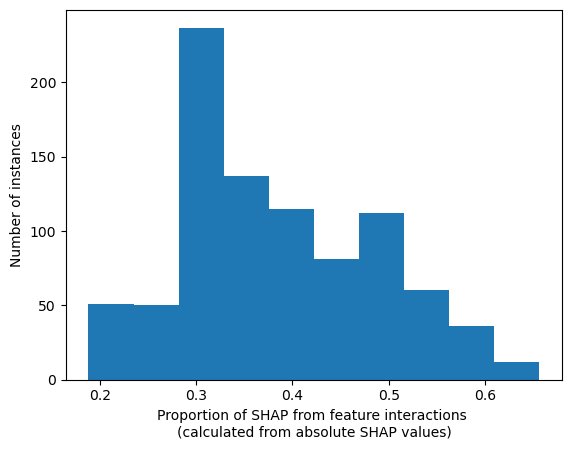

In [18]:
# sum the absolute interaction matrix per instance
abs_total_shap_per_instance = np.abs(shap_interaction).sum(axis=(1,2))

# Initialise list
proportion_interaction = []

# For each instance
for i in range(abs_total_shap_per_instance.shape[0]):
    # sum the absolute feature interactions (off diagonal positions)
    abs_interaction = (abs_total_shap_per_instance[i] - 
                       np.diagonal(np.abs(shap_interaction[i])).sum())
    # calculate the proportion from feature interactions
    proportion_interaction.append(
                abs_interaction / abs_total_shap_per_instance[i])

# plot as histogram
plt.hist(proportion_interaction);
plt.xlabel("Proportion of SHAP from feature interactions \n"
           "(calculated from absolute SHAP values)")
plt.ylabel("Number of instances")

### SHAP interaction matrix: represented as histograms 

Show the distribution of all of the instance values for each SHAP interation and SHAP main effect.

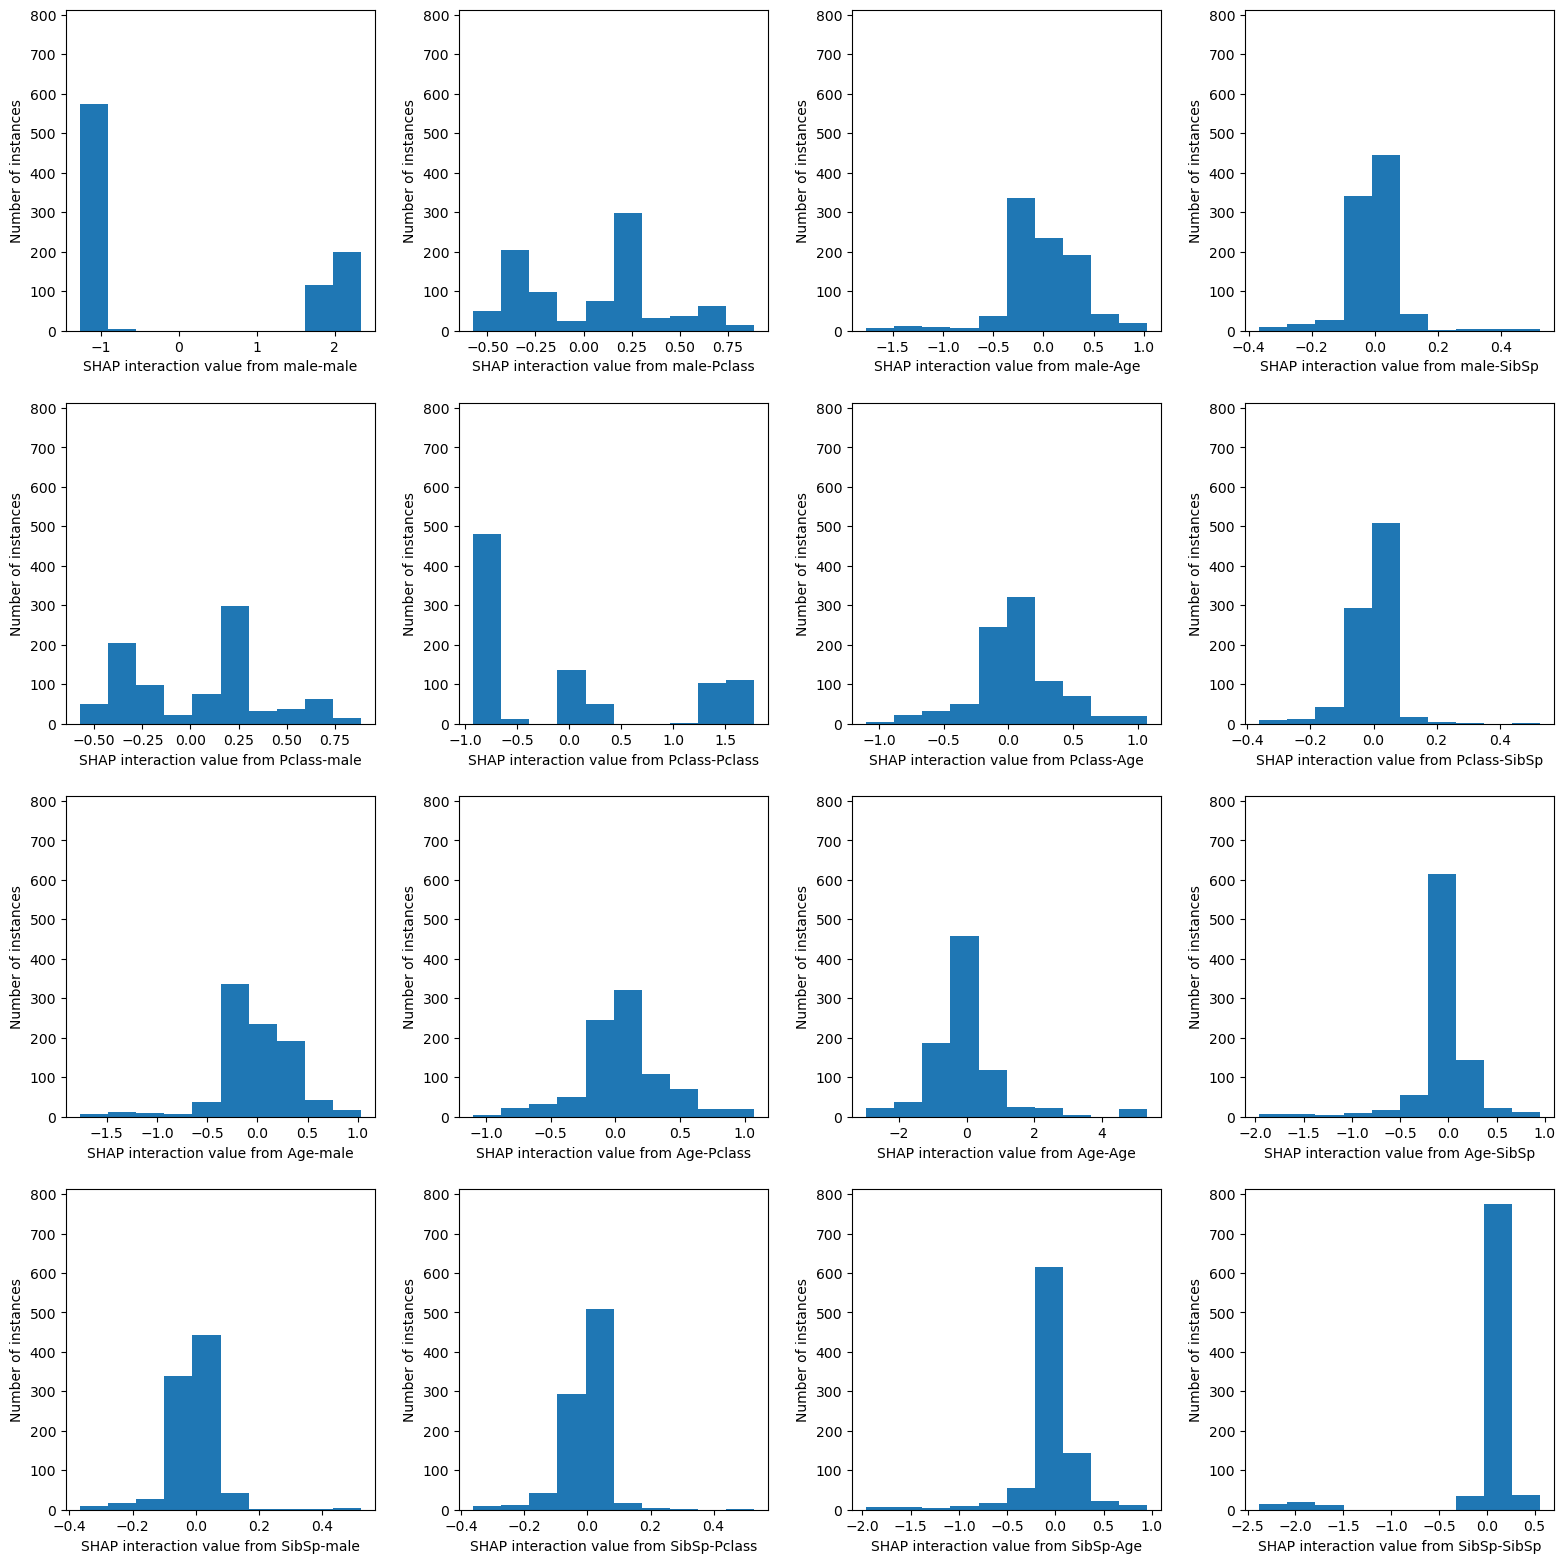

In [19]:
features = ["male","Pclass","Age","SibSp"]
n_features = len(features)

# Find the largest value used for the y axis in all of the histograms in the 
#   subplots (use this to set the max for each subplot)
y_max = -1
fig, axes = plt.subplots(1)
for i in range(n_features):
    for j in range(n_features):    
        axes.hist(shap_interaction[:,i,j])
        ylims = axes.get_ylim()
        # Store if greater than found so far
        y_max = max(y_max, ylims[1])
# Don't display plot
plt.close(fig)

# Setup figure with subplots
fig, axes = plt.subplots(
    nrows=len(features), 
    ncols=len(features))
axes = axes.ravel()        

count = 0
for i in range(n_features):
    for j in range(n_features):    
        ax=axes[count]
        ax.hist(shap_interaction[:,i,j])
        ax.set_xlabel(f"SHAP interaction value from {features[i]}-{features[j]}")
        ax.set_ylabel("Number of instances")
        ax.set_ylim(0, y_max)
        count += 1
        
fig.set_figheight(16)
fig.set_figwidth(16)
plt.tight_layout(pad=2)
#fig.subplots_adjust(hspace=0.4, wspace=0.9)
plt.show()

## Show a worked example for the first instance
Start with the feature values, and then show the SHAP values and how they can be represented as main effect and interactions. Also show that by summing them along with the base value gives the model output.

In [20]:
instance = 0
target_category = ["not survive", "survive"]
# Show data for first example
print ('Showing a worked example for the first instance')
print ('==============================================')
print ()
print ('------------------')
print ('Feature data values')
print ('------------------')
print (X.iloc[instance])

# Model output
prob_survive = y_proba[instance][1]
logodds_survive = np.log(prob_survive/(1 -prob_survive))
print ()
print ('-------------------')
print ('Model output values')
print ('-------------------')
print (f'1. Model probability [not survive, survive]: ' +
       f'{np.round(y_proba[instance],3)}')

print (f'\n2. Model log odds survive: {round(logodds_survive,3)}')
cat = np.int(y_pred[instance])
print (f'\n3. Model classification: {cat} ({target_category[cat]})')
print ()
print ('-----------------')
print ('SHAP base value (log odds)')
print ('---------------')
print (shap_values.base_values[instance])
print ('\nNote: This is the same value for all of the instances. This is the ' +
       'models best guess without additional knowledge about the instance')
print ()
print ('-----------------')
print ('SHAP values (log odds)')
print ('------------')
# print (example_shap)
v = shap_values.values[instance][0]
print (f'{X.columns.values[0]}: {v:0.3f}')
v = shap_values.values[instance][1]
print (f'{X.columns.values[1]}: {v:0.3f}')
v = shap_values.values[instance][2]
print (f'{X.columns.values[2]}: {v:0.3f}')
v = shap_values.values[instance][3]
print (f'{X.columns.values[3]}: {v:0.3f}')
# print (shap_values.values[instance])
v = shap_values.values[instance].sum()
print (f'Total = {v:0.3f}')
print ('\nNote: These are patient dependent')
print (f'\nThe "Model log odds survive" value ({logodds_survive:0.3g}, ' +
       f'see above) is calculated by adding up the SHAP base value ' +
       f'({shap_values.base_values[instance]:0.3f}, see above) with ' +
       f'all of the SHAP values for each feature ' +
       f'({shap_values.values[instance].sum():0.3f}, see above)')
print (f'{shap_values.base_values[instance]:0.3f} + ' +
       f'{shap_values.values[instance].sum():0.3f} = ' +
       f'{logodds_survive:0.3f}')

# SHAP interaction values for first employee
example_interaction = pd.DataFrame(shap_interaction[instance],
                                   index=X.columns,columns=X.columns)
row_total = example_interaction.sum(axis=0)
column_total = example_interaction.sum(axis=1)
total = example_interaction.sum().sum()
example_interaction['Total'] = row_total
example_interaction.loc['Total'] = column_total
example_interaction.loc['Total']['Total'] = total

print ()
print ('-----------------')
print ('SHAP interactions (log odds)')
print ('-----------------')
print ('\n* Each instance has a different SHAP value for the features. This ' +
       'is because the model is also capturing the interaction between pairs ' +
       'of features, and how that contributes to the features SHAP value.')
print ('* Each feature has a SHAP main effect (on the diagonal) and a SHAP ' +
       'interaction effect with each of the other features (off the diagonal)')
print ('* SHAP interaction is split symetrically, eg. age-male is the same ' +
       'as male-age.')
print ('* For each feature, the sum of the SHAP main effect and all of its ' +
       'SHAP interaction values = SHAP value for the feature (shown in ' +
       '"Total", and can be compared to the SHAP values above)')
print ()
print (example_interaction)

print ('------------------')
print ('\nThe model prediction for each instance can be arrived at by ' +
       'starting at the SHAP base value, and adding on the SHAP values from ' +
       'all of the the main effects (one per feature) and from all of the ' +
       'SHAP interactions (two per pair of features).')

Showing a worked example for the first instance

------------------
Feature data values
------------------
male       1.0
Pclass     3.0
Age       22.0
SibSp      1.0
Name: 0, dtype: float64

-------------------
Model output values
-------------------
1. Model probability [not survive, survive]: [0.865 0.135]

2. Model log odds survive: -1.856

3. Model classification: 0 (not survive)

-----------------
SHAP base value (log odds)
---------------
-0.5855415

Note: This is the same value for all of the instances. This is the models best guess without additional knowledge about the instance

-----------------
SHAP values (log odds)
------------
male: -0.954
Pclass: -0.458
Age: -0.195
SibSp: 0.337
Total = -1.270

Note: These are patient dependent

The "Model log odds survive" value (-1.86, see above) is calculated by adding up the SHAP base value (-0.586, see above) with all of the SHAP values for each feature (-1.270, see above)
-0.586 + -1.270 = -1.856

-----------------
SHAP interaction

## Sum of the SHAP value components (base + main effects + interactions) = model prediction 
We've seen a worked through example for one instance that the sum of the SHAP interactions and main effects and base value equals the model output (the log odds of predicted P). 

Here we show that it holds for all of the instances.

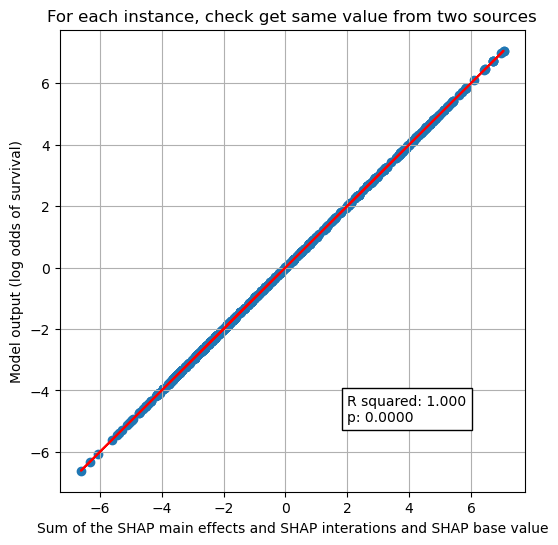

In [21]:
# Model output: probability survive
prob_survive = y_proba[:,1]
# Calculate log odds
logodds_survive = np.log(prob_survive/(1 -prob_survive))

# sum each matrix to get a value per instance
total_shap_per_instance = shap_values.base_values + shap_interaction.sum(axis=(1,2))

x1 = total_shap_per_instance
y1 = logodds_survive

# Fit a regression line to the points
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(x1, y1)
r_square = r_value ** 2
y_pred = intercept + (x1 * slope)

# Create scatter plot with regression line
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(x1, y1)
plt.plot (x1, y_pred, color = 'red')
text = f'R squared: {r_square:.3f}\np: {p_value:0.4f}'
ax1.text(2, -5, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
ax1.set_xlabel("Sum of the SHAP main effects and SHAP interations and SHAP base value")
ax1.set_ylabel("Model output (log odds of survival)")
plt.title("For each instance, check get same value from two sources")
plt.grid()
#plt.savefig('./output/scatter_plot_hosp_shap_vs_10k_thrombolysis.jpg', dpi=300,
#    bbox_inches='tight', pad_inches=0.2)

plt.show()

# Histogram of total SHAP

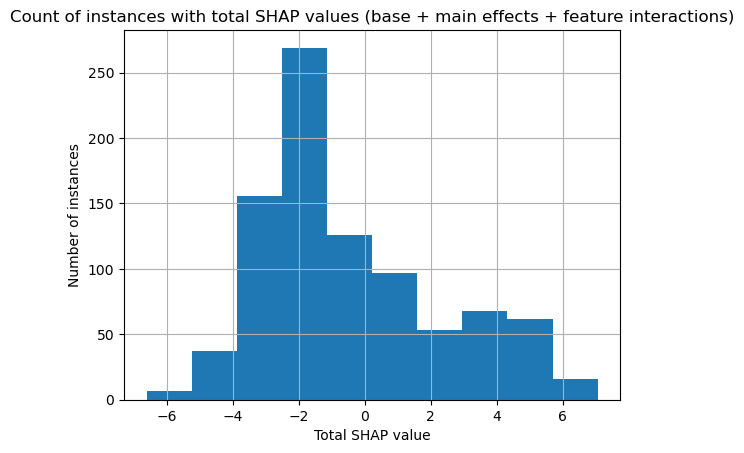

In [22]:
plt.hist(total_shap_per_instance)
plt.xlabel("Total SHAP value")
plt.ylabel("Number of instances")
plt.title("Count of instances with total SHAP values (base + main effects + feature interactions)")
plt.grid()
#plt.savefig('./output/scatter_plot_hosp_shap_vs_10k_thrombolysis.jpg', dpi=300,
#    bbox_inches='tight', pad_inches=0.2)

plt.show()

## How the SHAP main effect (or interaction) varies across the instances: using violin plots

### SHAP main effect of male-male

For this example lets focus on the feature "male". This feature has two possible values: males (1) and females (0).

From the histogram in the matrix showing the main effect for the feature male, we can see that there are ~550 instances with a male main effect of about -1, and ~300 instances with a male main effect of about 2.

From this we can not see which of these instances are which gender (male or female).

Here we will plot this same data using a violin plot, a violin for each gender.

We can see from the violin plot that the main effect (male-male) is quite different depending on whether the instance is male (a negative SHAP main effect value) or female (a positive SHAP main effect value).

This means that the feature will contribute a strong likelihood of survival if the instance is female, and a mid-strong likelihood of not surviving if the instance is male. This matches the story that we took from the beeswarm plot of the SHAP values, however as we have now extracted just the main effect the violin plot is showing a distinct effect for gender. That means that the points on the beeswarm that join up these two distinct groups are from the feature ilst.index(x)nteractions - they "muddy" the relationship (blur the edges, say) between the feature value and SHAP value. 

In [23]:
def plot_violin_shap_interaction(X, shap_interaction, main_feature, 
                                 interaction_feature):
    """
    Given the two features (main_feature and interaction_feature), plot the SHAP 
    interations as violin plots. 
    The main_feature will have it's data values displayed on the x axis. 
    The interaction_feature determines the SHAP interaction values that are 
    displayed in the violins.
    If the same feature name is in both (main_feature and interaction_feature)
    then the main effect will be displayed.
    
    X [pandas dataframe]: Feature per column, instance per row
    shap_interaction [3D numpy array]: [instance][feature][feature]
    main_feature [string]: feature name
    interaction_feature [string]: feature name
    
    """
    # Get the unqiue categories for the main feature
    category_list = list(X[main_feature].unique())

    # Setup dictionary and keys (key for each category, each key will hold a 
    #   list of SHAP interaction values for that category)
    shap_interaction_by_category_dict = {}
    for i in category_list:
        shap_interaction_by_category_dict[i]=[]
    
    # Store number of instances and number of categories
    n_instances = X.shape[0]
    n_categories = len(category_list)
    
    # For each instance put its instance interaction value in the corresponding 
    #   list (based on the instances category for the main feature)
    for i in range(n_instances):
        # Identify the instances category for the main feature
        category = X.iloc[i][main_feature]

        # Get the SHAP interaction value for the instance
        instance_interaction = pd.DataFrame(
            shap_interaction[i],index=X.columns,columns=X.columns)
        
        # Get the feature pairing interaction value
        value = instance_interaction.loc[main_feature][interaction_feature]

        # Store value in the dictionary using category as the key
        shap_interaction_by_category_dict[category].append(value)
    
    # Set violin width relative to count of instances
    width = [(len(shap_interaction_by_category_dict[category])/n_instances) 
             for category in category_list]

    # Create list of series to use in violin plot (one per violin)
    shap_per_category = [pd.Series(shap_interaction_by_category_dict[category]) 
                         for category in category_list]
    
    # create violin plot
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot()
    ax.violinplot(shap_per_category, showmedians=True, widths=width, )

    # customise the axes
    ax.set_title("")
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    ax.set_xticklabels(category_list, rotation=90, fontsize=12)
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(
        f'SHAP interaction value for {main_feature}-{interaction_feature}',
        fontsize=12)
    ax.set_xlabel(f'Feature: {main_feature}', fontsize=12)

    plt.subplots_adjust(bottom=0.15, wspace=0.05)

    # Add line at Shap = 0
    ax.plot([0, n_categories + 1], [0,0],c='0.5')
    
    return()

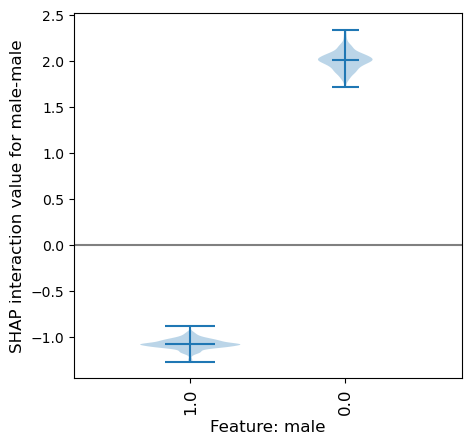

In [24]:
plot_violin_shap_interaction(X, shap_interaction, "male", "male");

### SHAP interaction of male-Pclass

We can also see the range of the SHAP interaction value between the features male-Pclass (divided by the male categories).

This shows that for females the SHAP interaction value between male-Pclass ranges from -0.6 to 0.9, and for males it has a smaller range (-0.6 to 0.3). Since this is in addition to the main effect (for which all females had a strong likelihood to survive), for some females their likelihood for surviving is further increased, whereas for others their likelihood for surviving is reduced - but never enough to have a likelihood of not surviving. Remember that we'd need to add on all of the other SHAP interations to get the likelihood of surviving for females.

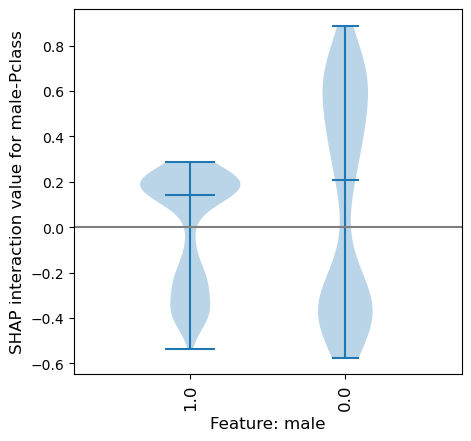

In [25]:
plot_violin_shap_interaction(X, shap_interaction, "male", "Pclass");

Violin plots can only display the values for one of the features in a feature-pairing - by it's placement on the x axis. In the violin plot above we can only see the value for the feature male, but not the value for the feature Pclass.

This can be solved by using a SHAP dependency plot - they can show the values for both features and the SHAP interaction value. This is shown in the following section, and we will introduce them using the same data as used in these two violin plots.

## How the SHAP main effect (or interaction) varies across the instances: using dependence plots

### SHAP main effect of male-male

We can see from the violin plot that the main effect (male-male) is quite different depending on whether the instance is male (a negative SHAP main effect value) or female (a positive SHAP main effect value).

This means that the feature will contribute a strong likelihood of survival if the instance is female, and a mid-strong likelihood of not surviving if the instance is male.

A dependence plot of the same data that's in the violin plot will represent it as individual points, instead of as a distribution. Doing so, it will plot all of the points on two points on the x axis: 0 for female, and 1 for male. A lot of information is lost due to overlap. To see more detail we add some jitter to the x-axis to spread the points out and so we cna get a sense of the density of the points in relation to the y value.

Here we see the same information as in the violin plot: the main effect (male-male) is quite different depending on whether the instance is male (a negative SHAP main effect value) or female (a positive SHAP main effect value).

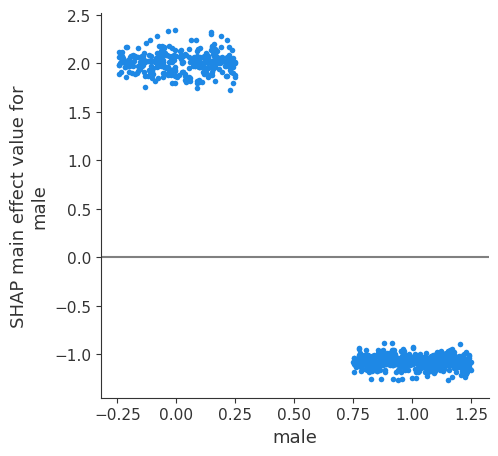

In [26]:
fig = plt.figure()
ax = fig.add_subplot()
shap.dependence_plot(
    ("male", "male"),
    shap_interaction, X,
    display_features=X,
    x_jitter=0.5,
    ax=ax,
    show=False)

# Add line at Shap = 0
n_violins = X["male"].nunique()
ax.plot([-1, n_violins], [0,0],c='0.5') 

fig.set_figheight(5)
fig.set_figwidth(5)

### SHAP interaction of male-Pclass

A hinderence of using a violin plot to show the data for the SHAP interaction of a feature pair is that we can only show one of the feature values (on the x axis). 

When using a dependence plot to show the data for the SHAP interaction of a feature pairing we can display both of the feature values: the point location on the x axis shows the value of one of the features, and the colour of the point shows the value of the other feature.

Note: The SHAP interaction for feature pairings (e.g. male-Pclass) is splt between male-Pclass and Pclass-male. The total SHAP interaction is therefore 2* the individual interactions. We could multiply the interation by 2 to get the full SHAP interaction. Here we will plot both permutations and acknowledge that it's the sum of the pair (LHS shows columns as male and colour as Pclass. RHS shows columns as Pclass and colour as male). Each graph contains the exact same data points, and it is possible to match up the identical block of data points across the graphs. For example the purple points in the LHS graph represent the Pclass 2, and we can see that for these points they have a positive SHAP interaction value for female (x-axis 0) and negative SHAP interaction value for male (x-axis 1). We can see these two blocks of purple points in the RHS graph, with both blocks now aligned on the x-axis with value 2, and now coloured blue for female (with positive SHAP interaction value) or red for male (with negative SHAP interaction value).

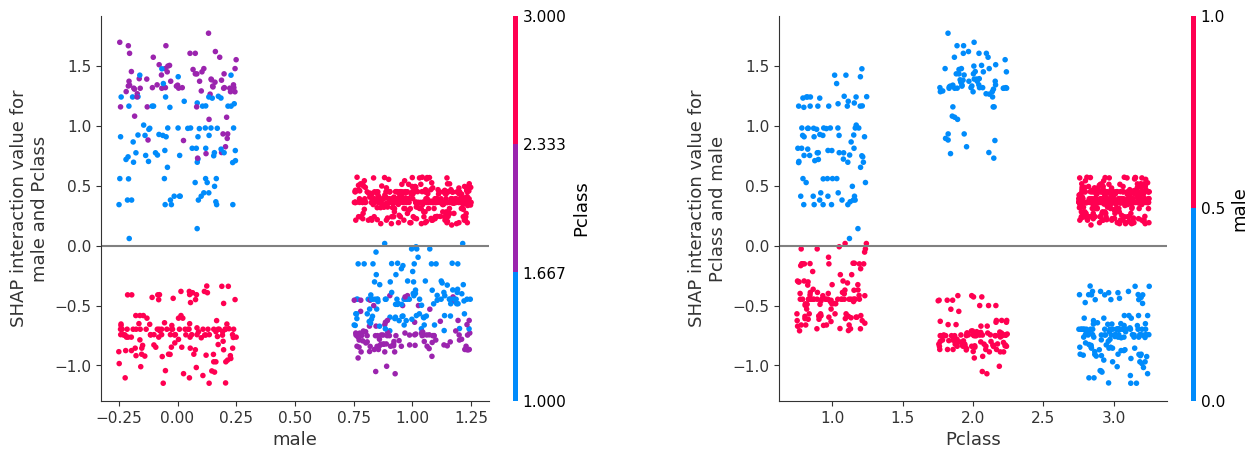

In [27]:
fig = plt.figure()
ax = fig.add_subplot(121)
shap.dependence_plot(
    ("male", "Pclass"),
    shap_interaction, X,
    display_features=X,
    x_jitter=0.5,
    ax=ax,
    show=False)

# Add line at Shap = 0
n_violins = X["male"].nunique()
ax.plot([-1, n_violins + 1], [0,0],c='0.5') 

ax1 = fig.add_subplot(122)
shap.dependence_plot(
    ("Pclass", "male"),
    shap_interaction, X,
    display_features=X,
    x_jitter=0.5,
    ax=ax1,
    show=False)

# Add line at Shap = 0
n_classes = X["Pclass"].nunique()
ax1.plot([-1, n_classes + 1], [0,0],c='0.5') 

fig.set_figheight(5)
fig.set_figwidth(15)
fig.subplots_adjust(wspace=.4)

## Grid of SHAP dependence plots

We will now show all of the SHAP interaction values in a grid of plots: each row and column represents a feature.

The diagonal graphs show the SHAP main effect for each feature. The SHAP interactions between features are off the diagonal, these are split symetrically (eg. age-male == male-age).

The SHAP main effect for feature male is shown in the top left (position [0, 0]). As already discussed, this shows that when the feature value is female, this has a strong contribution to the models prediction that the passenger will survive. And when this feature value is male there is a mid-strong contribution that the passenger will not survive.

The plot in position [1,1] shows the SHAP main effect for class. This shows that first class contributes a strong likelihood to survive, second class does not have much contribution, and third class contributes a strong likelihood not to survive.

But on top of these main effects we can see the contributon from the interation of these features. This is shown in positions [0, 1] and [1, 0]. The SHAP interaction between male and Pclass, and Pclass and male.

Graph in grid position [0, 1] (first row, second column) shows the SHAP interaction between male and Pclass, the data has been split into columns by the value of the gender feature (female on left, male on right), and the colour represents the class feature (first class = blue, second class = purple, third class = red). The value represents the contribution to the likelihood of this passenger surviving due to this combination of values - this is in addition to the main effect that we saw in the top left.

It can be seen that passengers in first or second class further increase the likelihood of survival for females, and not surviving for males, as the SHAP interation value is in the same sign to the SHAP main effect: A female passenger in first or second class will increase the likelihood of survival from the models prediction, and so will further help your survival in addition to the fact that you are female (as we saw in the SHAP main effect); similarly a male passenger in first or second class will increase the likelihood of not surviving, and so will further contribute to the likelihood that you will not survive, in addition to the fact that you are male (as we saw in the SHAP main effect).
However the converse is true for passengers in third class, as the SHAP interaction value is in the opposite sign to the SHAP main effect. A female passenger in third class will have a negative contribution to the survival (but remember that the main effect for female is a strong likelihood to survive), and if you are male in third class this combination will have a positive contribution to your survival (but remember that the main effect for male is a mid-strong likelihood to not survive).

The grid of dependency graphs are a mirror image across the diagonal. Meaning that the same data is shown in position [0,1] as in [1,0] just with the feature being displayed in the column or by colour is switched over.

Looking at the graph in position [1, 0] (second row, first column) shows the identical SHAP interation values for the features male - PClass, as we have just discussed above. Now the columns are per class (first, second, third) and the colour is by gender (male, female). Here we see that for first and second class females contributes that there is a mid likelihood to not survive, whereas if male then contributes a positive likelihood to survive. But that this is opposite for third class, where is it the females (red) with a positive likelihood to survive. This is also on top of the main effect from Pclass.

Resources used to make the grid of dependence plots: https://stackoverflow.com/questions/58510005/python-shap-package-how-to-plot-a-grid-of-dependence-plots \
(for future reference, but not yet used here: https://gist.github.com/eddjberry/3c1818a780d3cb17390744d6e215ba4d)

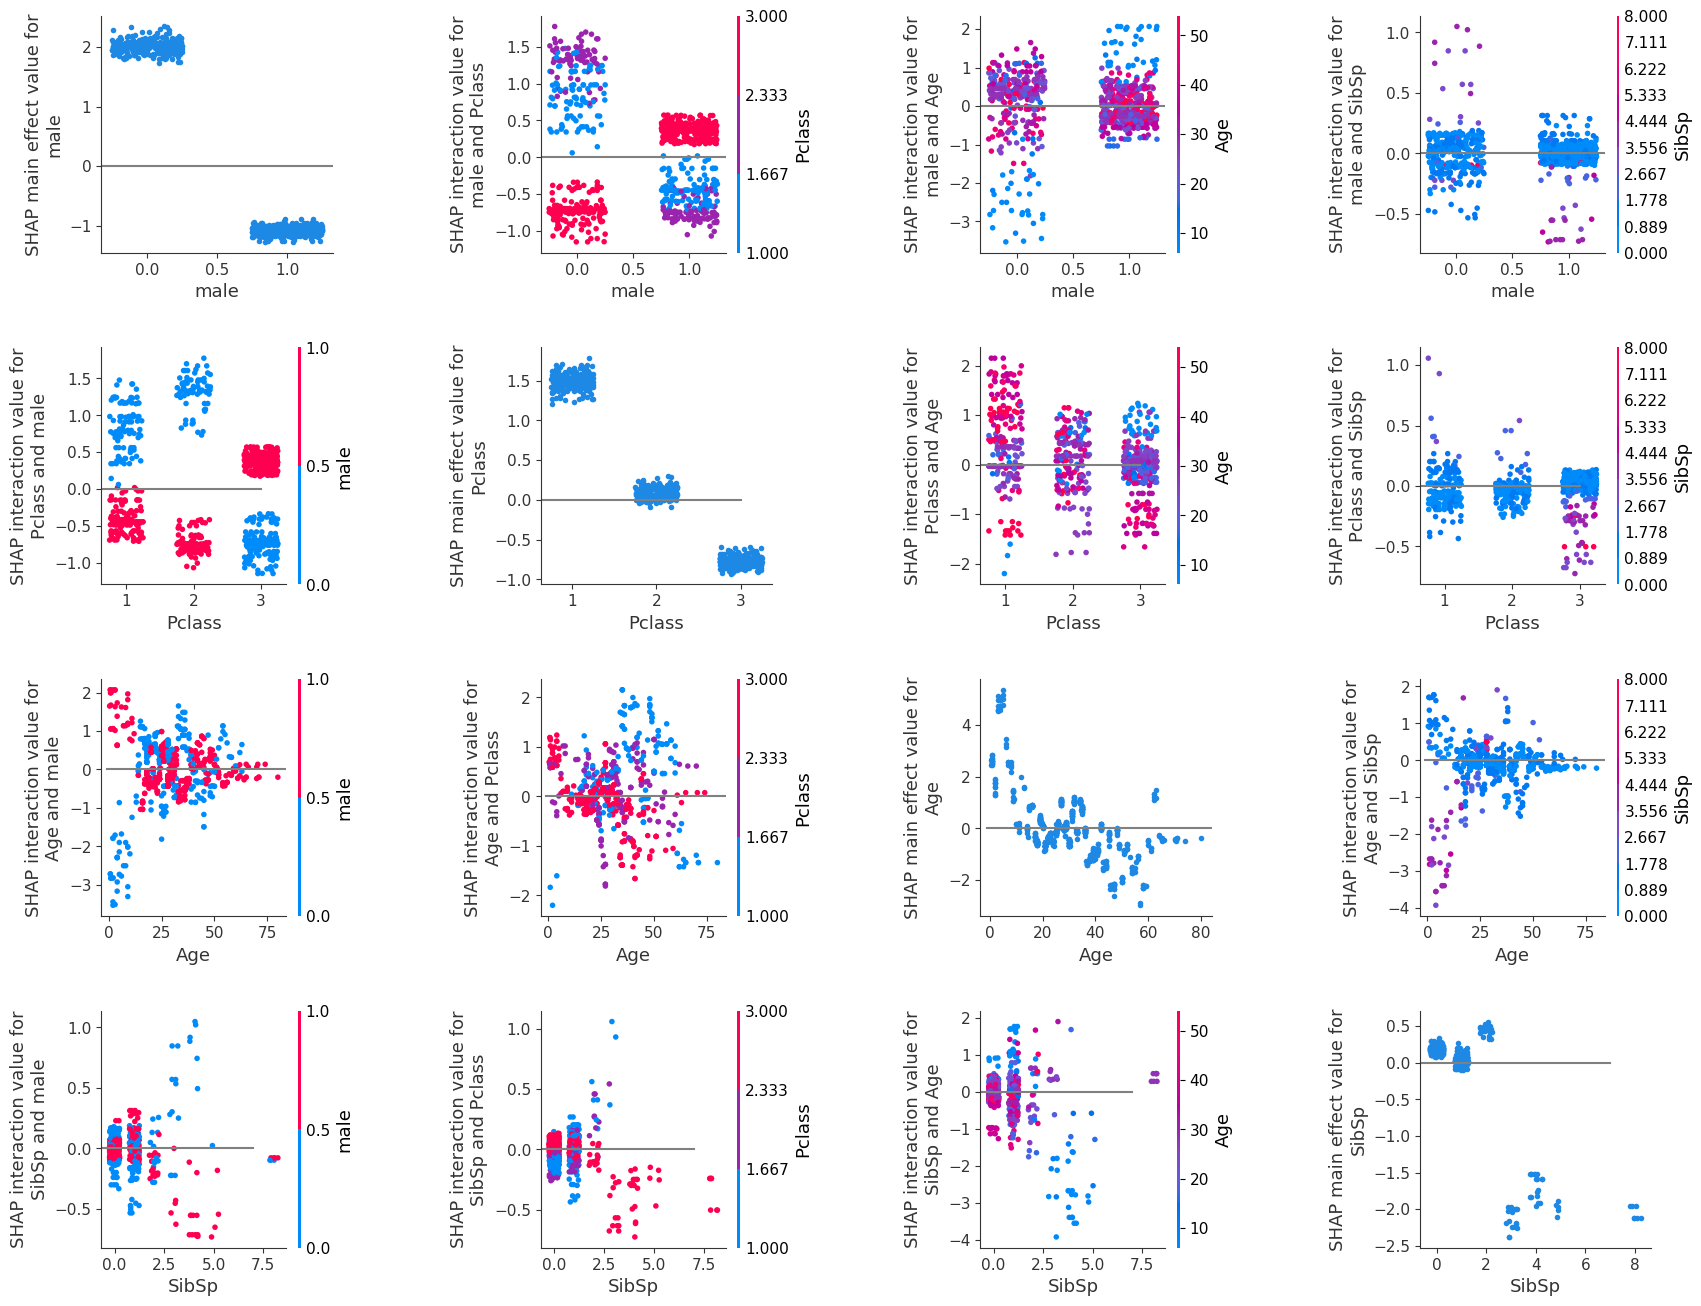

In [28]:
features = ["male","Pclass","Age","SibSp"]

fig, axes = plt.subplots(
    nrows=len(features), 
    ncols=len(features))
axes = axes.ravel()

count = 0
for f1 in features:
    for f2 in features:
        shap.dependence_plot(
            (f1, f2), shap_interaction, X, x_jitter=0.5, display_features=X,
            show=False, ax=axes[count])
        # Add line at Shap = 0
        n_classes = X[f1].nunique()
        axes[count].plot([-1, n_classes], [0,0],c='0.5')   
        count += 1
        
fig.set_figheight(16)
fig.set_figwidth(20)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.4, wspace=0.9)
plt.show()

Using the individual instance values you can unpick and understand how each instance gets their classification.

Each instance is represented in the grid of SHAP depencency plots, and so this shows all of the relationships that the model uses to derive it's predictions for the whole dataset. 

## Other SHAP plotting options

The SHAP library also offers other plotting options, such as a summary plot based on the beeswarm plot. 

We will show it here for completeness, however we found it to be tricky to interprete, and left gaps in our understanding of the relationships (it left us with further questions). 

It was due to this that we created our grid of dependency plots (as displayed above).

### SHAP interactions summary plot (a grid of beeswarms)

The beeswarm plot above showed the overall SHAP value for the feature. This next plot (a grid of beeswarms) shows the SHAP main effect and SHAP interactions for each feature. Each row and column represents a feature. The beeswarms on the diagonal represent the SHAP main effect for that feature, and those off the diagonal represent the SHAP interations with the other features.


The graphs are symmetrical around the diagonal, and so the shape of the data in the corresponding graph about the diagonal are the same, however the points are coloured based on the value of the feature represented by the row. For example, the first row this showing the feature male, so red represents the value male, and blue represents the value female. The second row shows the feature Pclass where blue represents first class, purple represents second class, and red represents third class. The third row shows the feature Age where blue represents the youngest, purple represent middle aged and red represents oldest. The fourth row shows the feature SibSp where blue represents no siblings, purple represents 3-4 siblings, and red represents seven siblings.

The shape of the data is based on the density of points that have the SHAP interaction value as displayed on the x axis. 

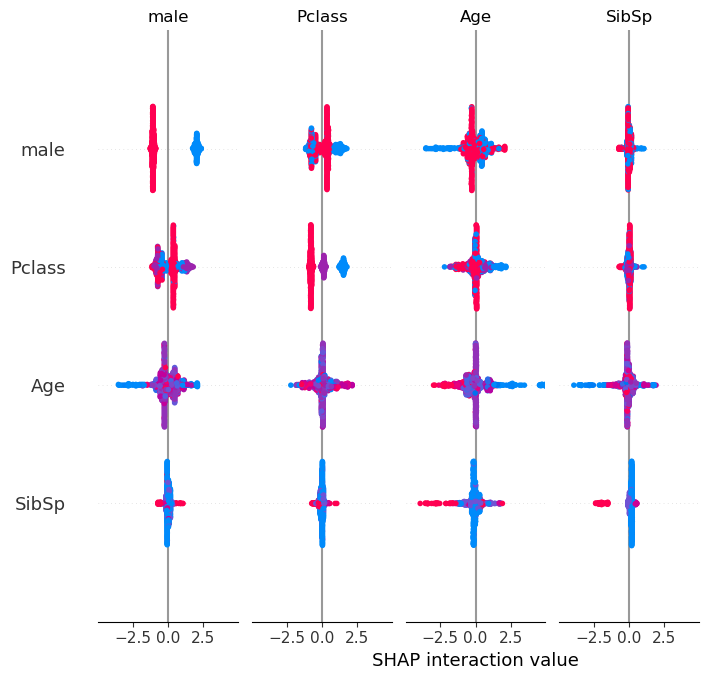

In [29]:
#Display summary plot
shap.summary_plot(shap_interaction, X, show=False)

## Observations

* SHAP interactions are awesome! 
* Viewing them as a grid of SHAP dependency plots clearly shows the overall relationships that the model uses to derive it's predictions for the whole dataset.